## School Versus Enrollment Area Demographics

Description


In [2]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from rowgenerators import dataframe, geoframe
import contextily as ctx

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

#import warnings
#warnings.filterwarnings('ignore')


In [12]:
##
## Open the packages we'll need
##

# Geo boundaries of enrollment zones, for San Diego Unified schools
pkg = mp.open_package('http://library.metatab.org/sandiegounified.org-enrollment_zones-2014-1.zip')
xwalk = pkg.resource('school_tract_xwalk').dataframe()
bound = pkg.resource('sdusd_boundaries').geoframe()

# Enrollment and race stats for all CA schools
enrol_pkg = mp.open_package('http://library.metatab.org/cde.ca.gov-enrollment-1.zip')
raceeth = enrol_pkg.resource('race_eth_07_18').dataframe()

# San Diego PLanning database, a cheap source for Census and ACS demographics
pdb_pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-planning-1.csv') 
pdb = pdb_pkg.resource('acs_pdb').dataframe(dtype=False) 



In [10]:
##
## Assemble race/eth demographics for hispanics, asiand and whites, 
## for the enrollment zone

dem_cols = ['pop_5_17','nh_white_alone','nh_asian_alone', 'hispanic' ]

dem_cols_t = dem_cols  + ['tot_population']

t = xwalk.merge(pdb[['geoid'] + dem_cols_t], on='geoid')

for c in dem_cols_t:
    t[c] = t[c] * t.tract_in_school

    
t.rename(columns={
    'nh_white_alone':'zone_white',
    'nh_asian_alone':'zone_asian',
    'hispanic':'zone_hisp',
    'tot_population':'zone_population'
}, inplace=True)
    
tc = t.groupby('cdscode').sum().reset_index()

# Calc percentages
for c in tc.columns:
    if 'zone_' in c and 'population' not in c:
        tc[c] = tc[c] / tc.zone_population
    
tc = tc[  ['cdscode'] + [c for c in tc.columns if 'zone_' in c] ]


In [13]:
##
## Assemble the race/eth stats for the schools

raceeth = raceeth[raceeth.year == 2016] # Maybe the same year as the census data
raceeth.rename(columns={
    'total':'school_population',
    'hisp':'school_hisp',
    'asian':'school_asian',
    'nh_white':'school_white'    
}, inplace=True)
raceeth = raceeth[['cdscode','school_white','school_asian','school_hisp','school_population']]

for c in raceeth.columns:
    if 'school_' in c and 'population' not in c:
        raceeth[c] = raceeth[c] / raceeth.school_population

raceeth = raceeth[  ['cdscode'] + [c for c in raceeth.columns if 'school_' in c] ]


In [14]:
##
## Merge into one dataframe

df = bound[['cdscode','school','group','geometry']].merge(tc, on='cdscode').merge(raceeth, on='cdscode')


0  \
cdscode                                               37683386039101   
school                                              Adams Elementary   
group                                                           ELEM   
geometry           POLYGON ((-117.112769590475 32.76521105221657,...   
zone_white                                                  0.501588   
zone_asian                                                 0.0450396   
zone_hisp                                                   0.316608   
zone_population                                              10632.8   
school_white                                               0.0742049   
school_asian                                               0.0141343   
school_hisp                                                 0.763251   
school_population                                                283   

                                                                   1  \
cdscode                                               37683386039119   
school                                             Alcott Elementary   
group                                                           ELEM   
geometry           POLYGON ((-117.2058996539639 32.8308577600889,...   
zone_white                                                  0.708643   
zone_asian                                                 0.0428193   
zone_hisp                                                   0.191585   
zone_population                                              6041.83   
school_white                                                 0.41206   
school_asian                                               0.0150754   
school_hisp                                                 0.437186   
school_population                                                199   

                                                                   2  \
cdscode                                               37683386039135   
school                                             Angier Elementary   
group                                                           ELEM   
geometry           POLYGON ((-117.1401186688951 32.8082601889782,...   
zone_white                                                  0.413658   
zone_asian                                                  0.142196   
zone_hisp                                                   0.227588   
zone_population                                              3554.03   
school_white                                                0.210721   
school_asian                                               0.0499076   
school_hisp                                                 0.247689   
school_population                                                541   

                                                                   3  \
cdscode                                               37683386039143   
school                                                   Audubon K-8   
group                                                           ELEM   
geometry           POLYGON ((-117.0223109888198 32.70982950149916...   
zone_white                                                 0.0979887   
zone_asian                                                  0.116245   
zone_hisp                                                   0.535897   
zone_population                                              7581.99   
school_white                                               0.0282609   
school_asian                                               0.0195652   
school_hisp                                                 0.758696   
school_population                                                460   

                                                                   4  
cdscode                                               37683386039150  
school                                              Baker Elementary  
group                                                           ELEM  
geometry           POLYGON ((-117.1

In [15]:
# Create a subset for platting ( select one of Elementary, Middle or High schools)
# And change the CRS to match the basemaps. 

plt_df = df[df.group=='MID'].to_crs(epsg=3857)

In [16]:
# From the Geopandas docs, a helper for adding a basemap
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [17]:
# Function for our particular visualization

def plot_maps(df, raceeth):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,10))

    for ax  in (ax1, ax2, ax3):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    f.suptitle(f'Demographics of Schools and Scholl Enrollment Zones\nPercentage {raceeth.title()}', fontsize=18);

    # Map 1
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    ax1.set_title('For Residents in School Enrollment Zone')
    df.plot(column=f'zone_{raceeth}', ax=ax1, cax=cax1,legend=True, alpha=0.9)

    add_basemap(ax1, zoom=12, url=ctx.sources.ST_TONER_LITE)

    # Map 2
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.1)
    ax2.set_title('For School')
    df.plot(column=f'school_{raceeth}', ax=ax2, cax=cax2, legend=True, alpha=0.9)

    add_basemap(ax2, zoom=12, url=ctx.sources.ST_TONER_LITE)

    # Map 3
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.1)
    ax3.set_title('Difference in Percentage Points\n')
    t = df.copy()
    t['raceeth_diff'] = (t[f'school_{raceeth}']-t[f'zone_{raceeth}']) #/ ((t.zone_white+t.school_white)/2)

    t.plot(column='raceeth_diff', legend=True, cmap='plasma', cax=cax3, ax=ax3, alpha=.9)

    add_basemap(ax3, zoom=12, url=ctx.sources.ST_TONER_LITE)

    f.tight_layout()

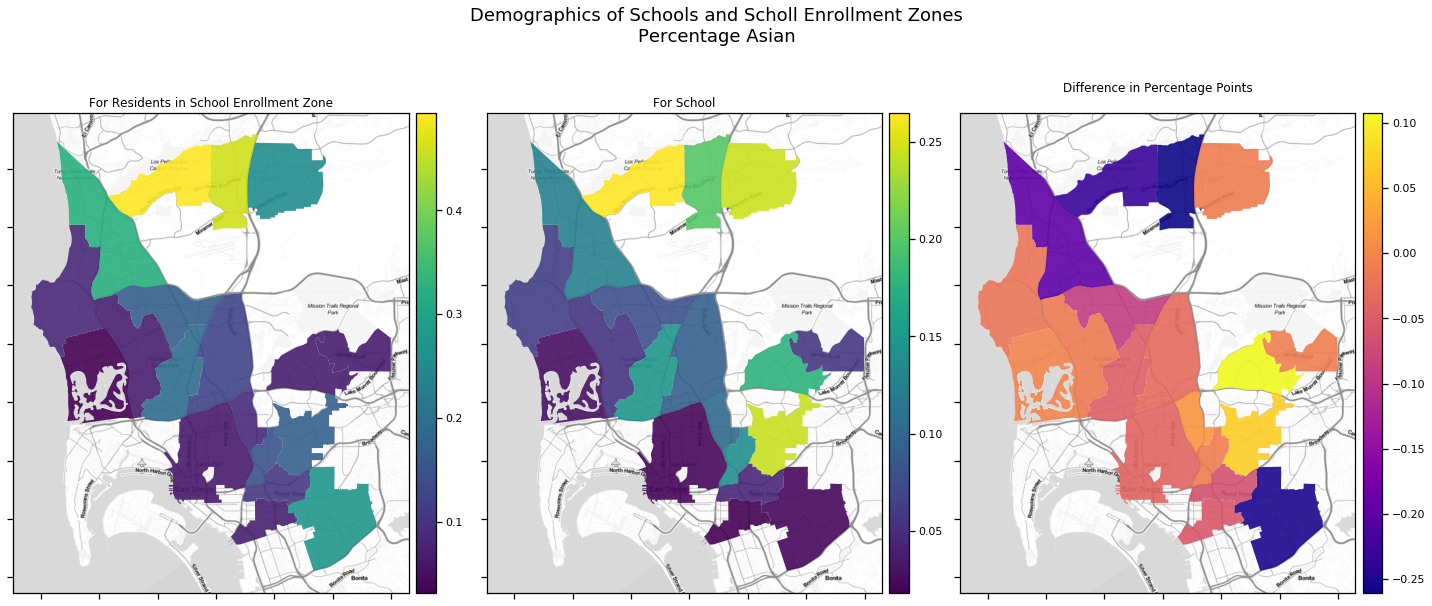

In [18]:
# Now we can do our plots. 
plot_maps(plt_df, 'asian')

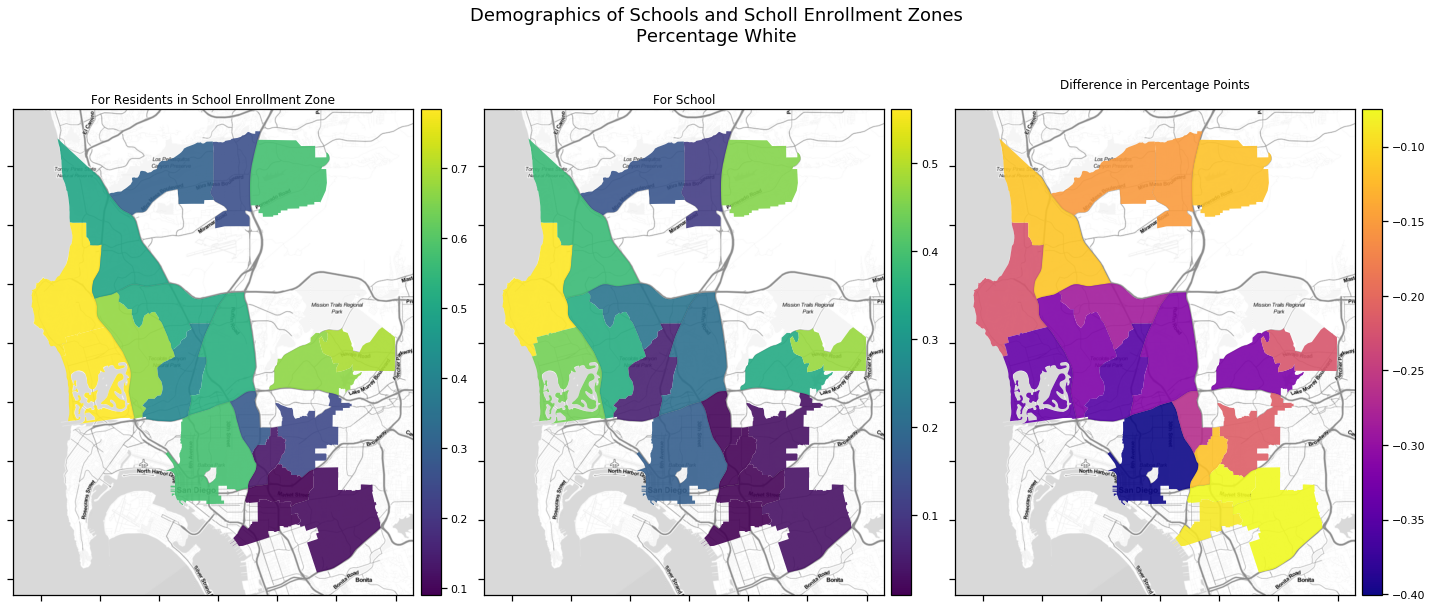

In [19]:
plot_maps(plt_df, 'white')

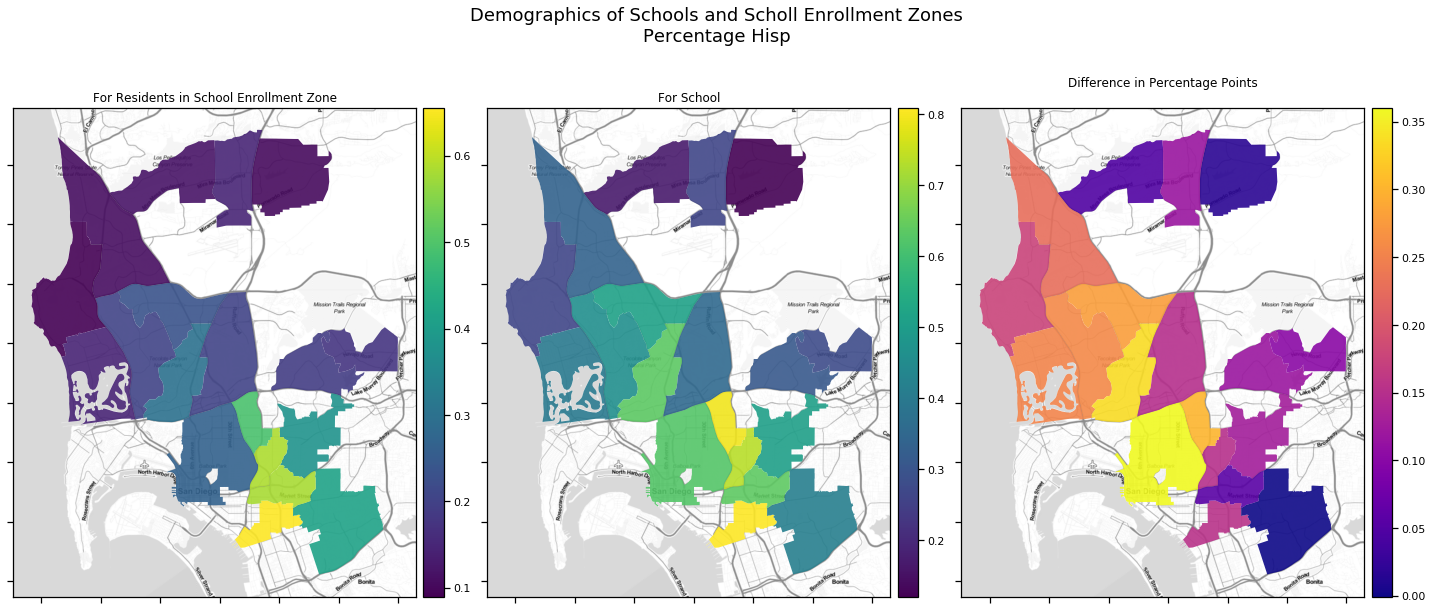

In [20]:
plot_maps(plt_df, 'hisp')